In [1]:
%matplotlib inline
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.offline as py
from bs4 import BeautifulSoup
from sklearn.model_selection import cross_validate, StratifiedKFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import make_scorer, accuracy_score, log_loss, f1_score
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import learning_curve


In [2]:
# Initialize Plotly notebook mode
py.init_notebook_mode(connected=True)

In [3]:
# Load dataset
data_set = pd.read_csv("C:\\Users\\HP\\Desktop\\jupyter projects\\mbti_1.csv")

In [4]:
# Define MBTI mapping
mbti = {
    'I': 'Introversion',
    'E': 'Extroversion',
    'N': 'Intuition',
    'S': 'Sensing',
    'T': 'Thinking',
    'F': 'Feeling',
    'J': 'Judging',
    'P': 'Perceiving'
}

In [5]:
# Check dataset shape
print(data_set.shape)

(8675, 2)


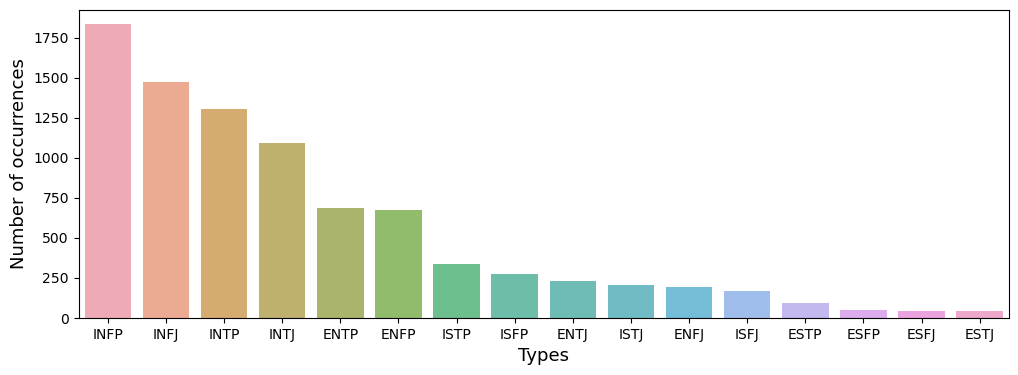

In [6]:
# Plot the distribution of types
cnt_srs = data_set['type'].value_counts()
plt.figure(figsize=(12, 4))
sns.barplot(x=cnt_srs.index, y=cnt_srs.values, alpha=0.8)
plt.ylabel("Number of occurrences", fontsize=13)
plt.xlabel("Types", fontsize=13)
plt.show()

In [7]:
# Define text cleaning function
def cleanText(text):
    text = BeautifulSoup(text, "lxml").text
    text = re.sub(r'\|\|\|', r'', text)
    text = re.sub(r'http\S+', r'<URL>', text)
    return text

In [8]:
# Apply text cleaning
data_set['clean_posts'] = data_set['posts'].apply(cleanText)


C:\Users\HP\AppData\Local\Temp\ipykernel_7324\1272902295.py:3: MarkupResemblesLocatorWarning:

The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.



In [9]:
# Define scoring metrics
scoring = {
    'accuracy': make_scorer(accuracy_score),
    'neg_log_loss': make_scorer(log_loss, greater_is_better=False),
    'f1_micro': make_scorer(f1_score, average='micro')
}

In [10]:
# Initialize models and pipelines
tfidf = TfidfVectorizer(ngram_range=(1, 1), stop_words="english")
tsvd = TruncatedSVD(n_components=10)
etc = ExtraTreesClassifier(n_estimators=20, max_depth=4, n_jobs=-1)

model_et = Pipeline([
    ('tfidf', tfidf),
    ('tsvd', tsvd),
    ('etc', etc)
])

nb = MultinomialNB()
model_nb = Pipeline([
    ('tfidf', tfidf),
    ('nb', nb)
])

lr = LogisticRegression(max_iter=1000)
model_lr = Pipeline([
    ('tfidf', tfidf),
    ('lr', lr)
])

In [11]:
# Initialize StratifiedKFold cross-validator
Kfolds = StratifiedKFold(n_splits=5, shuffle=True, random_state=1)

In [12]:
# Perform cross-validation with ExtraTreesClassifier
if len(data_set) > 5:
    X = data_set['posts']
    y = data_set['type']
    results_et = cross_validate(model_et, X, y, cv=Kfolds, scoring=scoring, n_jobs=-1)
    print("CV Accuracy (ExtraTrees): {:0.4f} (+/- {:0.4f})".format(np.mean(results_et['test_accuracy']), np.std(results_et['test_accuracy'])))
    print("CV F1 (ExtraTrees): {:0.4f} (+/- {:0.4f})".format(np.mean(results_et['test_f1_micro']), np.std(results_et['test_f1_micro'])))
    print("CV Logloss (ExtraTrees): {:0.4f} (+/- {:0.4f})".format(np.mean(results_et['test_neg_log_loss']), np.std(results_et['test_neg_log_loss'])))
else:
    print("Insufficient data for cross-validation with ExtraTrees.")

CV Accuracy (ExtraTrees): 0.2949 (+/- 0.0107)
CV F1 (ExtraTrees): 0.2949 (+/- 0.0107)
CV Logloss (ExtraTrees): nan (+/- nan)


In [13]:
# Perform cross-validation with MultinomialNB
if len(data_set) > 5:
    X = data_set['posts']
    y = data_set['type']
    try:
        results_nb = cross_validate(model_nb, X, y, cv=Kfolds, scoring=scoring, n_jobs=-1)
        print("CV Accuracy (MultinomialNB): {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_accuracy']), np.std(results_nb['test_accuracy'])))
        print("CV F1 (MultinomialNB): {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_f1_micro']), np.std(results_nb['test_f1_micro'])))
        print("CV Logloss (MultinomialNB): {:0.4f} (+/- {:0.4f})".format(np.mean(results_nb['test_neg_log_loss']), np.std(results_nb['test_neg_log_loss'])))
    except ValueError as e:
        print("Error during cross-validation with MultinomialNB:", e)
else:
    print("Insufficient data for cross-validation with MultinomialNB.")


CV Accuracy (MultinomialNB): 0.2114 (+/- 0.0002)
CV F1 (MultinomialNB): 0.2114 (+/- 0.0002)
CV Logloss (MultinomialNB): nan (+/- nan)


In [14]:
# Perform cross-validation with LogisticRegression
if len(data_set) > 5:
    X = data_set['posts']
    y = data_set['type']
    try:
        results_lr = cross_validate(model_lr, X, y, cv=Kfolds, scoring=scoring, n_jobs=-1)
        print("CV Accuracy (LogisticRegression): {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_accuracy']), np.std(results_lr['test_accuracy'])))
        print("CV F1 (LogisticRegression): {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_f1_micro']), np.std(results_lr['test_f1_micro'])))
        print("CV Logloss (LogisticRegression): {:0.4f} (+/- {:0.4f})".format(np.mean(results_lr['test_neg_log_loss']), np.std(results_lr['test_neg_log_loss'])))
    except ValueError as e:
        print("Error during cross-validation with LogisticRegression:", e)
else:
    print("Insufficient data for cross-validation with LogisticRegression.")

CV Accuracy (LogisticRegression): 0.6378 (+/- 0.0119)
CV F1 (LogisticRegression): 0.6378 (+/- 0.0119)
CV Logloss (LogisticRegression): nan (+/- nan)


In [ ]:
# Compute learning curve for LogisticRegression
train_sizes, train_scores, test_scores = learning_curve(model_lr, X, y, cv=Kfolds, n_jobs=-1, scoring='f1_micro', train_sizes=np.linspace(.1, 1.0, 10, endpoint=True))


In [ ]:
# Plot learning curve
def plot_learning_curve(X, y, train_sizes, train_scores, test_scores, title="Learning Curve", ylim=None, figsize=(14, 8)):
    plt.figure(figsize=figsize)
    plt.title(title)
    
    if ylim is not None:
        plt.ylim(*ylim)
        
    plt.xlabel('Training examples')
    plt.ylabel("Score")
    
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")
    plt.legend(loc="best")
    plt.show()

plot_learning_curve(X, y, train_sizes, train_scores, test_scores, ylim=(0.1, 1.01), figsize=(13, 6))


In [ ]:
# Apply text cleaning to new dataset
ps_join = pd.read_csv('C:\\Users\\HP\\Desktop\\jupyter projects\\mbti_1.csv')  # Replace with the path to your CSV file
ps_join['clean_comments'] = ps_join['posts'].apply(cleanText)

In [18]:
# Initialize and train the model
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('lr', LogisticRegression(max_iter=1000))
])
pipeline.fit(data_set['clean_posts'], data_set['type'])

Pipeline(steps=[('tfidf', TfidfVectorizer()),
                ('lr', LogisticRegression(max_iter=1000))])

In [19]:
# Predict using the cleaned comments
pred_all = pipeline.predict(ps_join['clean_comments'])

# Plot the distribution of predicted personalities
cnt_all = np.unique(pred_all, return_counts=True)
pred_df = pd.DataFrame({'personality': cnt_all[0], 'count': cnt_all[1]}, columns=['personality', 'count'])
pred_df.sort_values('count', ascending=False, inplace=True)
pred_df['percent'] = pred_df['count'] / pred_df['count'].sum()

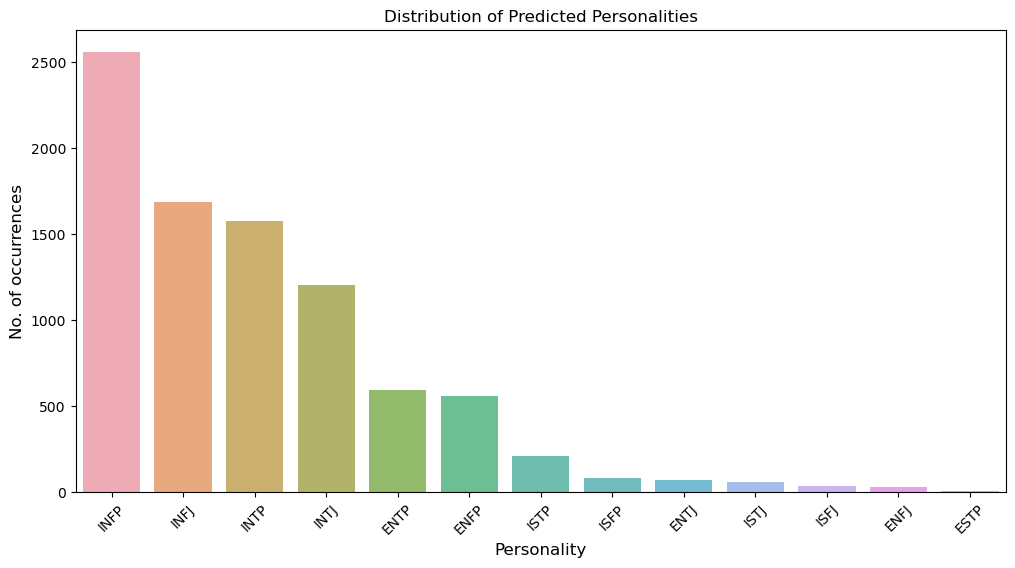

   personality  count   percent                                 description
6         INFP   2559  0.294986   Introversion Intuition Feeling Perceiving
5         INFJ   1685  0.194236      Introversion Intuition Feeling Judging
8         INTP   1580  0.182133  Introversion Intuition Thinking Perceiving
7         INTJ   1203  0.138674     Introversion Intuition Thinking Judging
3         ENTP    592  0.068242  Extroversion Intuition Thinking Perceiving
1         ENFP    558  0.064323   Extroversion Intuition Feeling Perceiving
12        ISTP    209  0.024092    Introversion Sensing Thinking Perceiving
10        ISFP     85  0.009798     Introversion Sensing Feeling Perceiving
2         ENTJ     71  0.008184     Extroversion Intuition Thinking Judging
11        ISTJ     57  0.006571       Introversion Sensing Thinking Judging
9         ISFJ     37  0.004265        Introversion Sensing Feeling Judging
0         ENFJ     33  0.003804      Extroversion Intuition Feeling Judging
4         ES

In [20]:
# Add descriptions
pred_df['description'] = pred_df['personality'].apply(lambda x: " ".join([mbti.get(l, l) for l in x]))

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='personality', y='count', data=pred_df, alpha=0.8)
plt.ylabel('No. of occurrences', fontsize=12)
plt.xlabel('Personality', fontsize=12)
plt.title('Distribution of Predicted Personalities')
plt.xticks(rotation=45)
plt.show()

print(pred_df)